last version with right number of exposure for the whole LSST survey (https://arxiv.org/pdf/0805.2366.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import cmath as cm
import math
import random
import scipy
from importlib import reload
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from multiprocess import *
import pandas as pd
import seaborn as sns

import pathlib
from pathlib import Path


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import plot, utils


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
%run -i ../../scripts/Images_generation/images_generator.py
%run -i ../../scripts/Images_generation/cosmos_params.py

1


In [4]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

# Test of recorded images

In [29]:
data_dir = '/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/miscentered_0.1/training/'
root = 'galaxies_blended_20191024'

In [30]:
images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [31]:
images.shape

(10000, 2, 10, 64, 64)

In [32]:
maxs = np.max(images[:,0,6], axis = (1,2))

In [33]:
maxs.shape

(10000,)

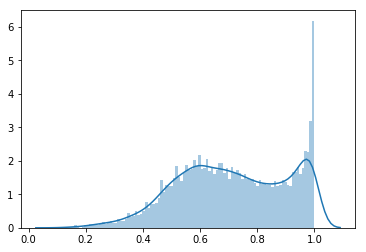

In [34]:
sns.distplot(maxs, bins = 100)

0.6057019094403011

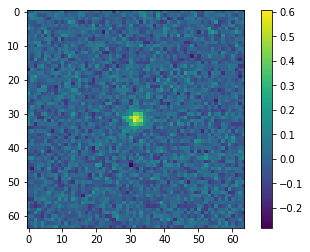

In [40]:
plt.imshow(images[100,1,6])
plt.colorbar()
np.max(images[100,1,6])

In [126]:
data_dir = '/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test'
root = 'galaxies_blended_20191024'

In [127]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

In [128]:
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test/galaxies_blended_20191024_0_shifts.npy')

In [129]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [130]:
test.shape

(10000, 2, 10, 64, 64)

In [131]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

In [132]:
input_noisy = test[:,1]
input_noiseless = test[:,0]

In [133]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [134]:
input_noisy = utils.norm(input_noisy, bands, data_dir, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands, data_dir, inplace = False)

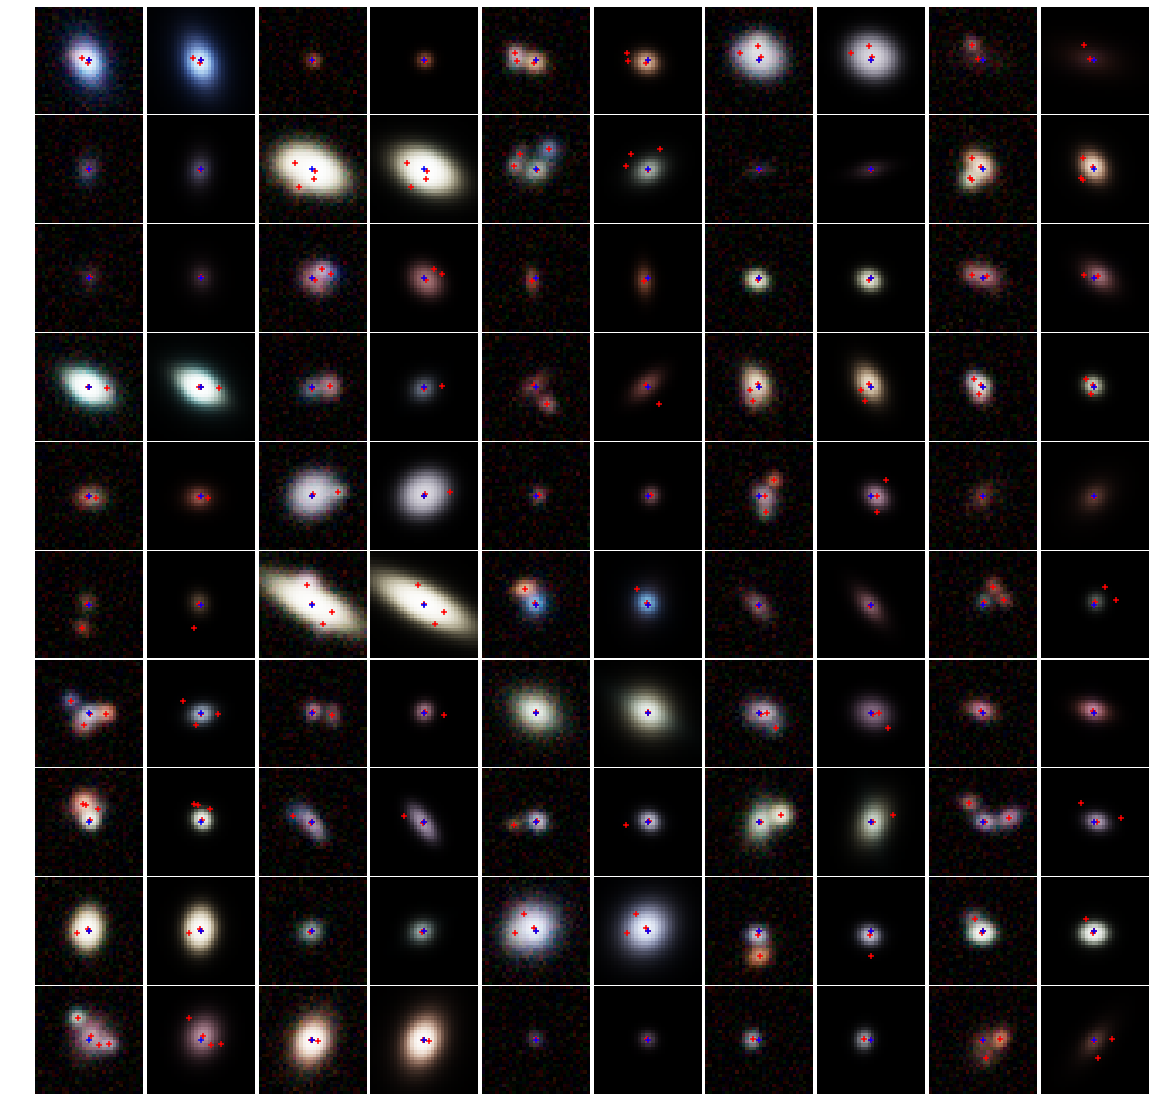

In [135]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [136]:
import astropy
import photutils

In [137]:
from photutils import find_peaks
from astropy.stats import sigma_clipped_stats

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

In [138]:
images = input_noiseless[:10000]

In [139]:
input_noisy = utils.denorm(input_noisy, bands,data_dir, inplace = False)

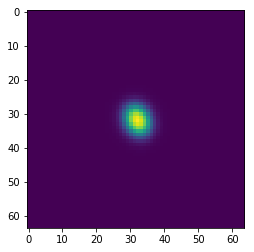

In [140]:
plt.imshow(images[41,6])

In [142]:
len(images)

10000

In [257]:
def peak_detection(denormed_img, band, shifts, img_size, npeaks, nb_blended_gal, training_or_test, dist_cut):
    gal = denormed_img
    df_temp = photutils.find_peaks(gal, threshold=5*np.sqrt(sky_level_pixel[band]), npeaks=npeaks, centroid_func=centroid_com)
    if df_temp is not None:
        df_temp['x_peak'] = (df_temp['x_centroid']-((img_size/2.)-0.5))*pixel_scale[band]
        df_temp['y_peak'] = (df_temp['y_centroid']-((img_size/2.)-0.5))*pixel_scale[band]
        df_temp.sort('peak_value', reverse=True)
        # Distances of true centers to brightest peak
        qq = [np.sqrt(float((shifts[j,0]-df_temp['x_peak'][0])**2+ (shifts[j,1]-df_temp['y_peak'][0])**2)) for j in range(nb_blended_gal)]
        idx_closest = np.argmin(qq)
        if nb_blended_gal>1:
            # Distance from peak galaxy to others
            qq_prime = [np.sqrt(float((shifts[idx_closest,0]-shifts[j,0])**2+ (shifts[idx_closest,1]-shifts[j,1])**2)) if j!=idx_closest else np.inf for j in range(nb_blended_gal)]
            idx_closest_to_peak_galaxy = np.argmin(qq_prime)
            if training_or_test != 'test':
                if not np.all(np.array(qq_prime) > dist_cut):
                    print('TRAINING CUT: closest is not central and others are too close')
                    return False
        else:
            idx_closest_to_peak_galaxy = np.nan
        return np.min(qq), idx_closest, idx_closest_to_peak_galaxy, df_temp[0]['x_centroid'], df_temp[0]['y_centroid'], df_temp[0]['x_peak'], df_temp[0]['y_peak'], len(df_temp)
    else:
        print('too bad')
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        #return False

In [258]:
band = 6
peak_detection_output = []

for i in range (len(input_noisy)):
    peak_detection_output.append(peak_detection(input_noisy[i,6],
                                   band, 
                                   shifts[i], 
                                   max_stamp_size, 
                                   4,
                                   df['nb_blended_gal'][i],
                                   'test', 
                                   dist_cut=0.65/2.))#/2.

too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad


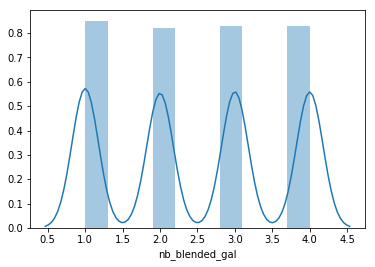

In [263]:
sns.distplot(df['nb_blended_gal'], bins = 10)

In [264]:
import scipy

In [265]:
np.array(peak_detection_output[0])

array([ 0.03538156,  0.        ,  1.        , 31.98572105, 31.93962042,
        0.09714421,  0.08792408,  2.        ])

In [266]:
df_peak = pd.DataFrame()

df_peak['min_dist'] = np.array(peak_detection_output)[:,0]
df_peak['idx_closest'] = np.array(peak_detection_output)[:,1]
df_peak['idx_closest_to_peak_galaxy'] = np.array(peak_detection_output)[:,2]
df_peak['x_centroid'] = np.array(peak_detection_output)[:,3]
df_peak['y_centroid'] = np.array(peak_detection_output)[:,4]
df_peak['x_peak'] = np.array(peak_detection_output)[:,5]
df_peak['y_peak'] = np.array(peak_detection_output)[:,6]
df_peak['nb'] = np.array(peak_detection_output)[:,7]

In [267]:
df_peak_new = df_peak.dropna()

In [268]:
df_peak_new['min_dist']

0       0.035382
1       0.101838
2       0.026296
5       0.116200
6       0.063589
7       0.039935
8       0.083979
10      0.038076
11      0.028690
12      0.056997
13      0.091954
14      0.101807
15      0.265432
18      0.036956
19      0.018334
20      0.143298
21      0.166903
22      0.136215
23      0.069249
25      0.052741
26      0.129275
27      0.089878
29      0.027605
30      0.075901
31      0.065601
32      0.172185
35      0.064995
37      0.054729
39      0.229031
40      0.046090
          ...   
9960    0.016621
9961    0.060907
9963    0.056756
9964    0.136353
9966    0.083186
9968    0.058921
9969    0.061648
9970    0.070466
9971    0.022963
9972    0.108926
9973    0.034154
9974    0.076279
9975    0.102109
9977    0.145973
9978    0.239152
9979    0.167531
9980    0.038632
9981    0.130128
9983    0.089117
9986    0.043617
9987    0.131286
9988    0.339965
9989    0.156895
9990    0.066623
9992    0.139195
9995    0.093022
9996    0.042378
9997    0.0636

In [269]:
# Old beta_prime parameters
beta_prime_parameters = (14.022429614276358, 6.922508843325913, -0.0247188726955977, 0.04994196562063914)

In [238]:
x = np.linspace(scipy.stats.betaprime.ppf(0.01,*beta_prime_parameters),
                scipy.stats.betaprime.ppf(0.99,*beta_prime_parameters), 100)

In [239]:
x

array([0.01140797, 0.0145101 , 0.01761222, 0.02071435, 0.02381647,
       0.0269186 , 0.03002072, 0.03312285, 0.03622497, 0.0393271 ,
       0.04242922, 0.04553135, 0.04863347, 0.0517356 , 0.05483772,
       0.05793985, 0.06104197, 0.0641441 , 0.06724622, 0.07034835,
       0.07345047, 0.0765526 , 0.07965472, 0.08275685, 0.08585897,
       0.0889611 , 0.09206322, 0.09516535, 0.09826747, 0.1013696 ,
       0.10447172, 0.10757385, 0.11067597, 0.1137781 , 0.11688022,
       0.11998235, 0.12308447, 0.1261866 , 0.12928872, 0.13239085,
       0.13549297, 0.1385951 , 0.14169722, 0.14479935, 0.14790147,
       0.1510036 , 0.15410572, 0.15720785, 0.16030998, 0.1634121 ,
       0.16651423, 0.16961635, 0.17271848, 0.1758206 , 0.17892273,
       0.18202485, 0.18512698, 0.1882291 , 0.19133123, 0.19443335,
       0.19753548, 0.2006376 , 0.20373973, 0.20684185, 0.20994398,
       0.2130461 , 0.21614823, 0.21925035, 0.22235248, 0.2254546 ,
       0.22855673, 0.23165885, 0.23476098, 0.2378631 , 0.24096

In [240]:
scipy.stats.betaprime.pdf(x,*beta_prime_parameters)

array([1.65548703, 2.30540015, 3.03462864, 3.81326949, 4.60988063,
       5.39463135, 6.14148329, 6.82942197, 7.44289661, 7.97167683,
       8.41033073, 8.75749635, 9.01507691, 9.18744964, 9.28074368,
       9.30221611, 9.25973683, 9.16138033, 9.0151155 , 8.8285807 ,
       8.6089302 , 8.36273829, 8.09594866, 7.81385794, 7.5211245 ,
       7.22179479, 6.91934134, 6.61670783, 6.31635761, 6.02032317,
       5.73025475, 5.4474667 , 5.17298094, 4.90756692, 4.651778  ,
       4.40598409, 4.17040071, 3.94511472, 3.73010675, 3.5252708 ,
       3.33043114, 3.14535688, 2.96977436, 2.8033777 , 2.64583771,
       2.49680931, 2.35593774, 2.22286371, 2.09722754, 1.97867258,
       1.86684792, 1.7614105 , 1.66202677, 1.56837395, 1.48014086,
       1.39702859, 1.31875084, 1.24503409, 1.17561765, 1.11025353,
       1.04870625, 0.99075254, 0.93618102, 0.88479178, 0.83639598,
       0.79081539, 0.74788194, 0.70743729, 0.6693323 , 0.63342662,
       0.59958824, 0.56769301, 0.53762427, 0.50927238, 0.48253

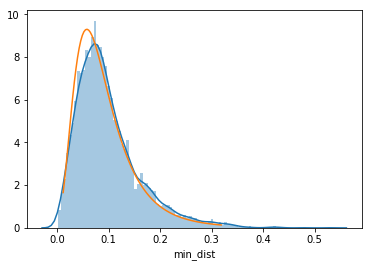

In [241]:
sns.distplot(df_peak_new['min_dist'], bins = 100, norm_hist = True)
plt.plot(x, scipy.stats.betaprime.pdf(x,*beta_prime_parameters))

In [249]:
new_parameters = scipy.stats.betaprime.fit(df_peak_new['min_dist'])
print(new_parameters)

(4.449289034920325, 12.777961268954916, -0.009031368689570645, 0.2840353229095878)


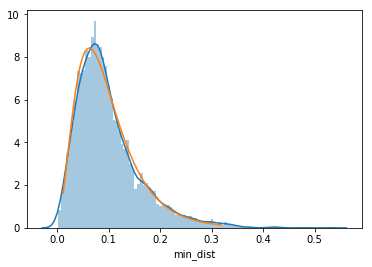

In [250]:
sns.distplot(df_peak_new['min_dist'], bins = 100, norm_hist = True)
plt.plot(x, scipy.stats.betaprime.pdf(x,*new_parameters))

In [106]:
shifts[:,].shape

(100, 4, 2)

In [252]:
np.array(peak_detection_output)[:,1]

array([0., 2., 1., ..., 1., 0., 0.])

In [253]:
np.shape(np.where(np.array(peak_detection_output)[:,1]!=0))

(1, 1716)

In [254]:
np.array(peak_detection_output).shape

(10000, 8)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
nb_blended_gal               100 non-null int64
SNR                          100 non-null float64
SNR_peak                     100 non-null float64
redshift                     100 non-null float64
moment_sigma                 100 non-null float64
e1                           100 non-null float64
e2                           100 non-null float64
mag                          100 non-null float64
mag_ir                       100 non-null float64
closest_x                    75 non-null float64
closest_y                    75 non-null float64
closest_redshift             75 non-null float64
closest_moment_sigma         75 non-null float64
closest_e1                   75 non-null float64
closest_e2                   75 non-null float64
closest_mag                  75 non-null float64
closest_mag_ir               75 non-null float64
blendedness_total_lsst       75 non-null float64
blended

In [256]:
len(df_peak_new['nb'])

7448

In [290]:
np.shape(np.where(np.isnan(df_peak['idx_closest'])))

(1, 19)

In [294]:
df_new = df.drop(np.where(np.isnan(df_peak['idx_closest']))[0])
df_peak_new_2 = df_peak.drop(np.where(np.isnan(df_peak['idx_closest']))[0])

In [296]:
plt.display(df_new['nb_blended_gal'], df_peak_new_2['nb'], '.')

AttributeError: module 'matplotlib.pyplot' has no attribute 'display'

In [297]:
df_heatmap = pd.DataFrame()

df_heatmap['nb_real'] = df_new['nb_blended_gal']
df_heatmap['nb_detected'] = df_peak_new_2['nb']

In [306]:
heatmap_arr[0,0]

0.0

In [334]:
heatmap_arr = np.zeros((4,4))

for i in range (len(df_new['nb_blended_gal'])):
    print(i)
    try:
        heatmap_arr[int(df_peak_new_2['nb'][i])-1, df_new['nb_blended_gal'][i]-1]+=1
        print(heatmap_arr)
    except KeyError as e:
            print(e)

0
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
1
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
2
[[0. 0. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
3
[[0. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
4
[[1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
5
[[1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
6
[[1. 0. 1. 0.]
 [1. 2. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
7
[[1. 1. 1. 0.]
 [1. 2. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
8
[[1. 1. 1. 1.]
 [1. 2. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
9
[[1. 1. 1. 1.]
 [2. 2. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
10
[[1. 1. 1. 1.]
 [2. 2. 1. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
11
[[1. 1. 1. 1.]
 [2. 2. 2. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
12
[[1. 1. 1. 1.]
 [2. 2. 3. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
13
[[1. 1. 1. 1.]
 [2. 2. 3. 0.]
 [0. 1. 0. 2.]
 [0. 0. 0. 0.]]
14
[[1. 1. 1. 1.]
 [2. 2. 3. 0.]
 [0. 1. 0. 2.]
 [0. 0. 0. 1.]]
15
[[1. 2. 1. 1.]
 [2. 2. 3. 0.]
 [0. 1. 0. 2.]
 [

398
[[70. 30. 24. 18.]
 [16. 43. 34. 33.]
 [ 3. 13. 27. 26.]
 [ 4.  9. 17. 31.]]
399
[[70. 30. 25. 18.]
 [16. 43. 34. 33.]
 [ 3. 13. 27. 26.]
 [ 4.  9. 17. 31.]]
400
[[71. 30. 25. 18.]
 [16. 43. 34. 33.]
 [ 3. 13. 27. 26.]
 [ 4.  9. 17. 31.]]
401
[[71. 30. 25. 18.]
 [17. 43. 34. 33.]
 [ 3. 13. 27. 26.]
 [ 4.  9. 17. 31.]]
402
[[71. 30. 26. 18.]
 [17. 43. 34. 33.]
 [ 3. 13. 27. 26.]
 [ 4.  9. 17. 31.]]
403
[[72. 30. 26. 18.]
 [17. 43. 34. 33.]
 [ 3. 13. 27. 26.]
 [ 4.  9. 17. 31.]]
404
[[72. 30. 26. 18.]
 [17. 43. 34. 33.]
 [ 3. 13. 28. 26.]
 [ 4.  9. 17. 31.]]
405
[[73. 30. 26. 18.]
 [17. 43. 34. 33.]
 [ 3. 13. 28. 26.]
 [ 4.  9. 17. 31.]]
406
[[73. 30. 26. 18.]
 [17. 43. 35. 33.]
 [ 3. 13. 28. 26.]
 [ 4.  9. 17. 31.]]
407
[[73. 30. 26. 18.]
 [17. 43. 35. 33.]
 [ 3. 13. 28. 26.]
 [ 4.  9. 17. 32.]]
408
[[73. 30. 26. 18.]
 [17. 43. 35. 33.]
 [ 3. 13. 28. 27.]
 [ 4.  9. 17. 32.]]
409
[[73. 30. 26. 18.]
 [17. 43. 35. 34.]
 [ 3. 13. 28. 27.]
 [ 4.  9. 17. 32.]]
410
[[73. 30. 26. 18.]
 [17.

 [  9.  16.  33.  60.]]
716
[[123.  62.  46.  30.]
 [ 22.  71.  64.  65.]
 [  6.  20.  43.  45.]
 [  9.  16.  33.  60.]]
717
[[123.  62.  46.  30.]
 [ 22.  71.  64.  65.]
 [  6.  20.  43.  46.]
 [  9.  16.  33.  60.]]
718
[[124.  62.  46.  30.]
 [ 22.  71.  64.  65.]
 [  6.  20.  43.  46.]
 [  9.  16.  33.  60.]]
719
[[124.  62.  46.  30.]
 [ 22.  71.  64.  65.]
 [  6.  20.  43.  46.]
 [  9.  16.  33.  61.]]
720
[[124.  62.  46.  30.]
 [ 22.  72.  64.  65.]
 [  6.  20.  43.  46.]
 [  9.  16.  33.  61.]]
721
[[124.  63.  46.  30.]
 [ 22.  72.  64.  65.]
 [  6.  20.  43.  46.]
 [  9.  16.  33.  61.]]
722
[[124.  63.  46.  30.]
 [ 22.  72.  64.  65.]
 [  6.  20.  43.  46.]
 [  9.  16.  34.  61.]]
723
[[124.  63.  46.  30.]
 [ 22.  72.  64.  65.]
 [  6.  20.  44.  46.]
 [  9.  16.  34.  61.]]
724
[[124.  63.  46.  30.]
 [ 22.  73.  64.  65.]
 [  6.  20.  44.  46.]
 [  9.  16.  34.  61.]]
725
[[124.  63.  46.  30.]
 [ 22.  73.  64.  65.]
 [  6.  20.  44.  46.]
 [  9.  16.  34.  62.]]
726
[[

 [  9.  21.  44.  74.]]
1001
[[180.  74.  59.  50.]
 [ 36. 104.  89. 101.]
 [ 11.  30.  56.  61.]
 [  9.  21.  44.  74.]]
1002
[[181.  74.  59.  50.]
 [ 36. 104.  89. 101.]
 [ 11.  30.  56.  61.]
 [  9.  21.  44.  74.]]
1003
[[181.  75.  59.  50.]
 [ 36. 104.  89. 101.]
 [ 11.  30.  56.  61.]
 [  9.  21.  44.  74.]]
1004
[[181.  75.  59.  50.]
 [ 36. 104.  89. 101.]
 [ 11.  30.  57.  61.]
 [  9.  21.  44.  74.]]
1005
[[181.  75.  59.  50.]
 [ 37. 104.  89. 101.]
 [ 11.  30.  57.  61.]
 [  9.  21.  44.  74.]]
1006
[[181.  75.  59.  51.]
 [ 37. 104.  89. 101.]
 [ 11.  30.  57.  61.]
 [  9.  21.  44.  74.]]
1007
[[181.  76.  59.  51.]
 [ 37. 104.  89. 101.]
 [ 11.  30.  57.  61.]
 [  9.  21.  44.  74.]]
1008
[[181.  76.  59.  51.]
 [ 37. 104.  89. 101.]
 [ 11.  30.  58.  61.]
 [  9.  21.  44.  74.]]
1009
[[181.  77.  59.  51.]
 [ 37. 104.  89. 101.]
 [ 11.  30.  58.  61.]
 [  9.  21.  44.  74.]]
1010
[[181.  77.  59.  51.]
 [ 37. 104.  89. 101.]
 [ 11.  30.  59.  61.]
 [  9.  21.  44.  74

 [ 10.  28.  55.  86.]]
1302
[[240. 105.  78.  67.]
 [ 45. 136. 120. 121.]
 [ 11.  43.  74.  80.]
 [ 10.  28.  55.  86.]]
1303
[[240. 105.  79.  67.]
 [ 45. 136. 120. 121.]
 [ 11.  43.  74.  80.]
 [ 10.  28.  55.  86.]]
1304
[[240. 106.  79.  67.]
 [ 45. 136. 120. 121.]
 [ 11.  43.  74.  80.]
 [ 10.  28.  55.  86.]]
1305
[[240. 106.  79.  67.]
 [ 45. 136. 120. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  28.  55.  86.]]
1306
[[240. 106.  79.  67.]
 [ 45. 136. 121. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  28.  55.  86.]]
1307
[[240. 106.  79.  67.]
 [ 45. 136. 122. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  28.  55.  86.]]
1308
[[240. 106.  79.  67.]
 [ 45. 136. 122. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  28.  56.  86.]]
1309
[[240. 106.  80.  67.]
 [ 45. 136. 122. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  28.  56.  86.]]
1310
[[240. 106.  80.  67.]
 [ 45. 136. 122. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  28.  56.  87.]]
1311
[[240. 106.  80.  67.]
 [ 45. 136. 122. 121.]
 [ 11.  43.  74.  81.]
 [ 10.  29.  56.  87

1647
[[308. 132. 103.  85.]
 [ 56. 177. 146. 147.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 109.]]
1648
[[308. 132. 103.  85.]
 [ 56. 177. 146. 147.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1649
[[308. 132. 103.  85.]
 [ 56. 177. 146. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1650
[[308. 133. 103.  85.]
 [ 56. 177. 146. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1651
[[308. 133. 103.  85.]
 [ 56. 177. 147. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1652
[[308. 133. 104.  85.]
 [ 56. 177. 147. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1653
[[308. 133. 104.  85.]
 [ 57. 177. 147. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1654
[[308. 133. 104.  85.]
 [ 57. 177. 148. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1655
[[308. 133. 104.  85.]
 [ 57. 177. 149. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1656
[[308. 133. 104.  85.]
 [ 57. 177. 150. 148.]
 [ 13.  53.  91. 102.]
 [ 15.  32.  75. 110.]]
1657
[[308. 134. 104

 [ 17.  40.  97. 134.]]
2005
[[382. 163. 122.  97.]
 [ 75. 216. 176. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 134.]]
2006
[[382. 163. 122.  97.]
 [ 75. 216. 177. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 134.]]
2007
[[382. 163. 122.  97.]
 [ 75. 216. 178. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 134.]]
2008
[[382. 164. 122.  97.]
 [ 75. 216. 178. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 134.]]
2009
[[382. 164. 122.  97.]
 [ 75. 216. 179. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 134.]]
2010
[[382. 164. 122.  97.]
 [ 75. 216. 179. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 135.]]
2011
[[383. 164. 122.  97.]
 [ 75. 216. 179. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 135.]]
2012
[[383. 164. 122.  97.]
 [ 75. 216. 179. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 136.]]
2013
[[383. 164. 122.  97.]
 [ 75. 217. 179. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 136.]]
2014
[[383. 164. 122.  97.]
 [ 75. 218. 179. 176.]
 [ 16.  63. 108. 119.]
 [ 17.  40.  97. 136

[[469. 185. 142. 119.]
 [ 86. 253. 207. 199.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2397
[[469. 185. 142. 119.]
 [ 87. 253. 207. 199.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2398
[[469. 185. 142. 119.]
 [ 87. 253. 207. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2399
[[469. 185. 142. 119.]
 [ 87. 253. 208. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2400
[[469. 185. 142. 119.]
 [ 87. 254. 208. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2401
[[469. 185. 142. 119.]
 [ 87. 255. 208. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2402
[[469. 185. 142. 120.]
 [ 87. 255. 208. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2403
[[469. 185. 143. 120.]
 [ 87. 255. 208. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2404
[[469. 185. 143. 120.]
 [ 87. 256. 208. 200.]
 [ 21.  80. 131. 150.]
 [ 17.  52. 120. 161.]]
2405
2405
2406
[[469. 185. 143. 120.]
 [ 87. 256. 208. 200.]
 [ 21.  80. 131. 151.]
 [ 17.  52. 120. 161.]]
2407
[[469. 185

 [ 19.  66. 138. 193.]]
2770
[[546. 207. 161. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  93. 156. 179.]
 [ 19.  66. 138. 193.]]
2771
[[547. 207. 161. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  93. 156. 179.]
 [ 19.  66. 138. 193.]]
2772
[[548. 207. 161. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  93. 156. 179.]
 [ 19.  66. 138. 193.]]
2773
[[548. 207. 162. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  93. 156. 179.]
 [ 19.  66. 138. 193.]]
2774
[[548. 207. 162. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  94. 156. 179.]
 [ 19.  66. 138. 193.]]
2775
[[549. 207. 162. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  94. 156. 179.]
 [ 19.  66. 138. 193.]]
2776
[[549. 207. 163. 134.]
 [ 95. 294. 233. 225.]
 [ 25.  94. 156. 179.]
 [ 19.  66. 138. 193.]]
2777
[[549. 207. 163. 135.]
 [ 95. 294. 233. 225.]
 [ 25.  94. 156. 179.]
 [ 19.  66. 138. 193.]]
2778
[[549. 207. 163. 135.]
 [ 95. 294. 233. 225.]
 [ 25.  94. 156. 179.]
 [ 19.  66. 138. 194.]]
2779
[[549. 207. 163. 135.]
 [ 95. 295. 233. 225.]
 [ 25.  94. 156. 179.]
 [ 19.  66. 138. 194

 [ 21.  74. 149. 209.]]
3049
[[613. 221. 182. 144.]
 [107. 325. 257. 245.]
 [ 28. 102. 170. 195.]
 [ 21.  74. 149. 209.]]
3050
[[613. 221. 182. 144.]
 [107. 325. 257. 246.]
 [ 28. 102. 170. 195.]
 [ 21.  74. 149. 209.]]
3051
[[614. 221. 182. 144.]
 [107. 325. 257. 246.]
 [ 28. 102. 170. 195.]
 [ 21.  74. 149. 209.]]
3052
[[615. 221. 182. 144.]
 [107. 325. 257. 246.]
 [ 28. 102. 170. 195.]
 [ 21.  74. 149. 209.]]
3053
[[615. 221. 182. 144.]
 [107. 325. 257. 246.]
 [ 28. 102. 171. 195.]
 [ 21.  74. 149. 209.]]
3054
[[615. 221. 182. 145.]
 [107. 325. 257. 246.]
 [ 28. 102. 171. 195.]
 [ 21.  74. 149. 209.]]
3055
[[615. 221. 182. 145.]
 [107. 325. 258. 246.]
 [ 28. 102. 171. 195.]
 [ 21.  74. 149. 209.]]
3056
[[615. 221. 182. 145.]
 [107. 325. 258. 246.]
 [ 28. 103. 171. 195.]
 [ 21.  74. 149. 209.]]
3057
[[615. 221. 183. 145.]
 [107. 325. 258. 246.]
 [ 28. 103. 171. 195.]
 [ 21.  74. 149. 209.]]
3058
[[615. 221. 183. 145.]
 [107. 325. 258. 246.]
 [ 28. 103. 171. 195.]
 [ 21.  74. 150. 209

 [ 23.  81. 167. 228.]]
3418
[[706. 239. 197. 162.]
 [120. 363. 294. 271.]
 [ 29. 114. 195. 222.]
 [ 23.  81. 167. 228.]]
3419
[[707. 239. 197. 162.]
 [120. 363. 294. 271.]
 [ 29. 114. 195. 222.]
 [ 23.  81. 167. 228.]]
3420
[[707. 239. 197. 162.]
 [120. 363. 295. 271.]
 [ 29. 114. 195. 222.]
 [ 23.  81. 167. 228.]]
3421
[[707. 239. 197. 162.]
 [120. 363. 296. 271.]
 [ 29. 114. 195. 222.]
 [ 23.  81. 167. 228.]]
3422
[[708. 239. 197. 162.]
 [120. 363. 296. 271.]
 [ 29. 114. 195. 222.]
 [ 23.  81. 167. 228.]]
3423
[[708. 239. 197. 162.]
 [120. 363. 296. 271.]
 [ 29. 114. 196. 222.]
 [ 23.  81. 167. 228.]]
3424
[[708. 239. 197. 162.]
 [120. 363. 297. 271.]
 [ 29. 114. 196. 222.]
 [ 23.  81. 167. 228.]]
3425
[[708. 239. 197. 162.]
 [120. 363. 298. 271.]
 [ 29. 114. 196. 222.]
 [ 23.  81. 167. 228.]]
3426
[[708. 239. 197. 162.]
 [120. 363. 299. 271.]
 [ 29. 114. 196. 222.]
 [ 23.  81. 167. 228.]]
3427
[[708. 239. 197. 162.]
 [120. 363. 300. 271.]
 [ 29. 114. 196. 222.]
 [ 23.  81. 167. 228

 [ 27.  91. 195. 260.]]
3838
[[795. 262. 214. 181.]
 [133. 405. 343. 304.]
 [ 29. 129. 222. 239.]
 [ 27.  91. 195. 260.]]
3839
[[795. 263. 214. 181.]
 [133. 405. 343. 304.]
 [ 29. 129. 222. 239.]
 [ 27.  91. 195. 260.]]
3840
[[795. 263. 215. 181.]
 [133. 405. 343. 304.]
 [ 29. 129. 222. 239.]
 [ 27.  91. 195. 260.]]
3841
[[795. 263. 215. 181.]
 [133. 406. 343. 304.]
 [ 29. 129. 222. 239.]
 [ 27.  91. 195. 260.]]
3842
[[795. 263. 216. 181.]
 [133. 406. 343. 304.]
 [ 29. 129. 222. 239.]
 [ 27.  91. 195. 260.]]
3843
[[795. 263. 216. 181.]
 [133. 406. 343. 304.]
 [ 29. 130. 222. 239.]
 [ 27.  91. 195. 260.]]
3844
[[796. 263. 216. 181.]
 [133. 406. 343. 304.]
 [ 29. 130. 222. 239.]
 [ 27.  91. 195. 260.]]
3845
[[796. 263. 216. 181.]
 [134. 406. 343. 304.]
 [ 29. 130. 222. 239.]
 [ 27.  91. 195. 260.]]
3846
[[796. 263. 216. 181.]
 [134. 406. 343. 304.]
 [ 29. 130. 223. 239.]
 [ 27.  91. 195. 260.]]
3847
[[796. 263. 216. 181.]
 [134. 407. 343. 304.]
 [ 29. 130. 223. 239.]
 [ 27.  91. 195. 260

 [ 32.  96. 218. 286.]]
4244
[[872. 300. 235. 202.]
 [148. 444. 367. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  96. 218. 286.]]
4245
[[872. 300. 235. 203.]
 [148. 444. 367. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  96. 218. 286.]]
4246
[[873. 300. 235. 203.]
 [148. 444. 367. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  96. 218. 286.]]
4247
[[873. 301. 235. 203.]
 [148. 444. 367. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  96. 218. 286.]]
4248
[[873. 301. 235. 203.]
 [148. 444. 367. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  97. 218. 286.]]
4249
[[874. 301. 235. 203.]
 [148. 444. 367. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  97. 218. 286.]]
4250
[[874. 301. 235. 203.]
 [148. 444. 368. 338.]
 [ 33. 149. 249. 266.]
 [ 32.  97. 218. 286.]]
4251
[[874. 301. 235. 203.]
 [148. 444. 368. 338.]
 [ 33. 149. 249. 267.]
 [ 32.  97. 218. 286.]]
4252
[[874. 301. 235. 203.]
 [148. 445. 368. 338.]
 [ 33. 149. 249. 267.]
 [ 32.  97. 218. 286.]]
4253
[[874. 302. 235. 203.]
 [148. 445. 368. 338.]
 [ 33. 149. 249. 267.]
 [ 32.  97. 218. 286

4645
[[959. 342. 255. 223.]
 [161. 484. 405. 361.]
 [ 35. 161. 268. 298.]
 [ 34. 105. 235. 310.]]
4646
[[959. 342. 255. 224.]
 [161. 484. 405. 361.]
 [ 35. 161. 268. 298.]
 [ 34. 105. 235. 310.]]
4647
[[959. 342. 255. 225.]
 [161. 484. 405. 361.]
 [ 35. 161. 268. 298.]
 [ 34. 105. 235. 310.]]
4648
[[959. 342. 255. 225.]
 [161. 484. 405. 362.]
 [ 35. 161. 268. 298.]
 [ 34. 105. 235. 310.]]
4649
[[959. 342. 256. 225.]
 [161. 484. 405. 362.]
 [ 35. 161. 268. 298.]
 [ 34. 105. 235. 310.]]
4650
[[959. 342. 256. 225.]
 [161. 484. 405. 362.]
 [ 35. 161. 268. 299.]
 [ 34. 105. 235. 310.]]
4651
[[959. 342. 256. 225.]
 [161. 484. 405. 362.]
 [ 35. 161. 268. 300.]
 [ 34. 105. 235. 310.]]
4652
[[959. 342. 256. 225.]
 [162. 484. 405. 362.]
 [ 35. 161. 268. 300.]
 [ 34. 105. 235. 310.]]
4653
[[959. 342. 256. 226.]
 [162. 484. 405. 362.]
 [ 35. 161. 268. 300.]
 [ 34. 105. 235. 310.]]
4654
[[959. 342. 256. 226.]
 [162. 484. 406. 362.]
 [ 35. 161. 268. 300.]
 [ 34. 105. 235. 310.]]
4655
[[960. 342. 256

 [  35.  113.  250.  328.]]
4997
[[1035.  367.  282.  236.]
 [ 170.  521.  441.  395.]
 [  36.  175.  283.  321.]
 [  35.  113.  250.  328.]]
4998
[[1035.  367.  282.  236.]
 [ 170.  521.  442.  395.]
 [  36.  175.  283.  321.]
 [  35.  113.  250.  328.]]
4999
[[1035.  367.  282.  236.]
 [ 170.  521.  442.  395.]
 [  36.  175.  283.  321.]
 [  35.  113.  251.  328.]]
5000
[[1035.  367.  282.  236.]
 [ 170.  521.  442.  395.]
 [  36.  175.  283.  321.]
 [  35.  113.  251.  329.]]
5001
[[1036.  367.  282.  236.]
 [ 170.  521.  442.  395.]
 [  36.  175.  283.  321.]
 [  35.  113.  251.  329.]]
5002
[[1036.  367.  282.  236.]
 [ 170.  521.  442.  396.]
 [  36.  175.  283.  321.]
 [  35.  113.  251.  329.]]
5003
[[1036.  367.  282.  236.]
 [ 170.  521.  442.  396.]
 [  36.  176.  283.  321.]
 [  35.  113.  251.  329.]]
5004
[[1037.  367.  282.  236.]
 [ 170.  521.  442.  396.]
 [  36.  176.  283.  321.]
 [  35.  113.  251.  329.]]
5005
[[1037.  367.  282.  236.]
 [ 170.  522.  442.  396.]
 

 [  36.  118.  270.  352.]]
5354
[[1109.  403.  299.  248.]
 [ 186.  572.  458.  421.]
 [  38.  186.  304.  344.]
 [  36.  118.  270.  352.]]
5355
[[1109.  403.  299.  248.]
 [ 186.  573.  458.  421.]
 [  38.  186.  304.  344.]
 [  36.  118.  270.  352.]]
5356
[[1110.  403.  299.  248.]
 [ 186.  573.  458.  421.]
 [  38.  186.  304.  344.]
 [  36.  118.  270.  352.]]
5357
[[1110.  403.  299.  248.]
 [ 187.  573.  458.  421.]
 [  38.  186.  304.  344.]
 [  36.  118.  270.  352.]]
5358
[[1110.  403.  299.  248.]
 [ 187.  574.  458.  421.]
 [  38.  186.  304.  344.]
 [  36.  118.  270.  352.]]
5359
[[1110.  403.  299.  248.]
 [ 187.  574.  458.  421.]
 [  38.  187.  304.  344.]
 [  36.  118.  270.  352.]]
5360
[[1110.  403.  300.  248.]
 [ 187.  574.  458.  421.]
 [  38.  187.  304.  344.]
 [  36.  118.  270.  352.]]
5361
[[1110.  404.  300.  248.]
 [ 187.  574.  458.  421.]
 [  38.  187.  304.  344.]
 [  36.  118.  270.  352.]]
5362
[[1110.  404.  300.  248.]
 [ 187.  574.  458.  421.]
 

 [  39.  131.  283.  382.]]
5838
[[1217.  438.  328.  264.]
 [ 206.  626.  502.  460.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5839
[[1217.  438.  328.  264.]
 [ 206.  626.  502.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5840
[[1217.  438.  328.  264.]
 [ 206.  626.  503.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5841
[[1217.  438.  328.  264.]
 [ 206.  627.  503.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5842
[[1217.  438.  328.  264.]
 [ 206.  628.  503.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5843
[[1217.  438.  328.  264.]
 [ 206.  629.  503.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5844
[[1217.  438.  328.  264.]
 [ 206.  629.  504.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5845
[[1217.  438.  328.  264.]
 [ 207.  629.  504.  461.]
 [  42.  211.  322.  376.]
 [  39.  131.  283.  383.]]
5846
[[1217.  438.  328.  264.]
 [ 207.  629.  504.  461.]
 

 [  44.  139.  300.  405.]]
6261
[[1309.  465.  343.  287.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  139.  300.  405.]]
6262
[[1309.  465.  343.  288.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  139.  300.  405.]]
6263
[[1309.  465.  343.  288.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  139.  300.  406.]]
6264
[[1309.  465.  343.  288.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  140.  300.  406.]]
6265
[[1310.  465.  343.  288.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  140.  300.  406.]]
6266
[[1310.  465.  344.  288.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  140.  300.  406.]]
6267
[[1311.  465.  344.  288.]
 [ 225.  680.  543.  496.]
 [  43.  227.  347.  398.]
 [  44.  140.  300.  406.]]
6268
[[1311.  465.  344.  288.]
 [ 225.  680.  543.  496.]
 [  43.  228.  347.  398.]
 [  44.  140.  300.  406.]]
6269
[[1311.  465.  344.  288.]
 [ 225.  680.  543.  496.]
 

 [  45.  151.  319.  431.]]
6555
[[1365.  486.  355.  305.]
 [ 234.  709.  562.  511.]
 [  45.  239.  373.  414.]
 [  45.  151.  319.  431.]]
6556
[[1365.  486.  355.  305.]
 [ 234.  709.  562.  511.]
 [  45.  239.  373.  415.]
 [  45.  151.  319.  431.]]
6557
[[1365.  486.  355.  305.]
 [ 234.  710.  562.  511.]
 [  45.  239.  373.  415.]
 [  45.  151.  319.  431.]]
6558
[[1365.  486.  355.  305.]
 [ 234.  710.  562.  512.]
 [  45.  239.  373.  415.]
 [  45.  151.  319.  431.]]
6559
[[1365.  486.  356.  305.]
 [ 234.  710.  562.  512.]
 [  45.  239.  373.  415.]
 [  45.  151.  319.  431.]]
6560
[[1365.  486.  356.  305.]
 [ 234.  710.  562.  512.]
 [  45.  239.  374.  415.]
 [  45.  151.  319.  431.]]
6561
[[1366.  486.  356.  305.]
 [ 234.  710.  562.  512.]
 [  45.  239.  374.  415.]
 [  45.  151.  319.  431.]]
6562
6562
6563
[[1366.  486.  356.  305.]
 [ 234.  710.  562.  512.]
 [  45.  239.  374.  415.]
 [  45.  151.  320.  431.]]
6564
[[1366.  486.  356.  305.]
 [ 234.  710.  563

 [  49.  165.  335.  468.]]
7037
[[1447.  527.  384.  327.]
 [ 253.  774.  594.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7038
[[1447.  527.  384.  327.]
 [ 253.  775.  594.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7039
[[1447.  527.  384.  327.]
 [ 254.  775.  594.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7040
[[1447.  527.  384.  327.]
 [ 254.  775.  595.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7041
[[1447.  527.  384.  327.]
 [ 254.  775.  596.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7042
[[1447.  527.  384.  327.]
 [ 254.  776.  596.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7043
[[1447.  528.  384.  327.]
 [ 254.  776.  596.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7044
[[1448.  528.  384.  327.]
 [ 254.  776.  596.  535.]
 [  51.  258.  405.  452.]
 [  49.  165.  335.  468.]]
7045
[[1448.  528.  384.  327.]
 [ 254.  776.  596.  535.]
 

 [  52.  169.  348.  492.]]
7400
[[1517.  555.  402.  343.]
 [ 266.  825.  628.  564.]
 [  56.  269.  434.  465.]
 [  52.  169.  348.  492.]]
7401
[[1518.  555.  402.  343.]
 [ 266.  825.  628.  564.]
 [  56.  269.  434.  465.]
 [  52.  169.  348.  492.]]
7402
[[1518.  556.  402.  343.]
 [ 266.  825.  628.  564.]
 [  56.  269.  434.  465.]
 [  52.  169.  348.  492.]]
7403
[[1518.  556.  402.  343.]
 [ 266.  825.  629.  564.]
 [  56.  269.  434.  465.]
 [  52.  169.  348.  492.]]
7404
[[1518.  556.  402.  343.]
 [ 266.  825.  629.  564.]
 [  56.  270.  434.  465.]
 [  52.  169.  348.  492.]]
7405
[[1518.  556.  403.  343.]
 [ 266.  825.  629.  564.]
 [  56.  270.  434.  465.]
 [  52.  169.  348.  492.]]
7406
[[1518.  556.  403.  343.]
 [ 266.  825.  629.  564.]
 [  56.  270.  434.  465.]
 [  53.  169.  348.  492.]]
7407
[[1518.  556.  403.  343.]
 [ 266.  826.  629.  564.]
 [  56.  270.  434.  465.]
 [  53.  169.  348.  492.]]
7408
[[1518.  556.  403.  343.]
 [ 266.  826.  629.  565.]
 

 [  59.  180.  370.  524.]]
7816
[[1605.  588.  429.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  457.  484.]
 [  59.  180.  370.  524.]]
7817
[[1605.  588.  429.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  457.  484.]
 [  59.  181.  370.  524.]]
7818
[[1606.  588.  429.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  457.  484.]
 [  59.  181.  370.  524.]]
7819
[[1606.  588.  430.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  457.  484.]
 [  59.  181.  370.  524.]]
7820
[[1607.  588.  430.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  457.  484.]
 [  59.  181.  370.  524.]]
7821
[[1607.  588.  430.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  458.  484.]
 [  59.  181.  370.  524.]]
7822
[[1607.  588.  430.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  458.  485.]
 [  59.  181.  370.  524.]]
7823
[[1607.  588.  430.  361.]
 [ 276.  868.  666.  591.]
 [  57.  286.  459.  485.]
 [  59.  181.  370.  524.]]
7824
[[1607.  588.  430.  361.]
 [ 276.  869.  666.  591.]
 

 [  62.  192.  383.  541.]]
8152
[[1651.  610.  447.  384.]
 [ 289.  916.  705.  616.]
 [  62.  300.  478.  501.]
 [  62.  192.  383.  541.]]
8153
[[1651.  611.  447.  384.]
 [ 289.  916.  705.  616.]
 [  62.  300.  478.  501.]
 [  62.  192.  383.  541.]]
8154
[[1651.  611.  447.  384.]
 [ 289.  917.  705.  616.]
 [  62.  300.  478.  501.]
 [  62.  192.  383.  541.]]
8155
[[1651.  611.  447.  384.]
 [ 289.  917.  705.  616.]
 [  62.  300.  478.  501.]
 [  62.  192.  384.  541.]]
8156
[[1651.  611.  447.  384.]
 [ 289.  917.  706.  616.]
 [  62.  300.  478.  501.]
 [  62.  192.  384.  541.]]
8157
[[1651.  611.  447.  384.]
 [ 289.  917.  706.  616.]
 [  62.  300.  478.  502.]
 [  62.  192.  384.  541.]]
8158
[[1651.  611.  447.  384.]
 [ 289.  917.  707.  616.]
 [  62.  300.  478.  502.]
 [  62.  192.  384.  541.]]
8159
[[1651.  611.  447.  384.]
 [ 289.  917.  707.  616.]
 [  62.  300.  478.  502.]
 [  62.  192.  384.  542.]]
8160
[[1651.  611.  447.  384.]
 [ 289.  918.  707.  616.]
 

 [  65.  203.  402.  570.]]
8606
[[1746.  651.  473.  407.]
 [ 303.  966.  746.  657.]
 [  65.  315.  496.  525.]
 [  65.  203.  402.  570.]]
8607
[[1746.  651.  473.  407.]
 [ 303.  966.  746.  657.]
 [  65.  315.  497.  525.]
 [  65.  203.  402.  570.]]
8608
[[1746.  651.  474.  407.]
 [ 303.  966.  746.  657.]
 [  65.  315.  497.  525.]
 [  65.  203.  402.  570.]]
8609
[[1746.  652.  474.  407.]
 [ 303.  966.  746.  657.]
 [  65.  315.  497.  525.]
 [  65.  203.  402.  570.]]
8610
[[1747.  652.  474.  407.]
 [ 303.  966.  746.  657.]
 [  65.  315.  497.  525.]
 [  65.  203.  402.  570.]]
8611
[[1747.  652.  474.  407.]
 [ 303.  966.  746.  657.]
 [  65.  315.  497.  526.]
 [  65.  203.  402.  570.]]
8612
[[1747.  652.  474.  407.]
 [ 303.  966.  746.  657.]
 [  65.  316.  497.  526.]
 [  65.  203.  402.  570.]]
8613
[[1748.  652.  474.  407.]
 [ 303.  966.  746.  657.]
 [  65.  316.  497.  526.]
 [  65.  203.  402.  570.]]
8614
[[1749.  652.  474.  407.]
 [ 303.  966.  746.  657.]
 

 [  66.  210.  424.  597.]]
9074
[[1847.  690.  499.  421.]
 [ 319. 1029.  789.  679.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  597.]]
9075
[[1847.  690.  500.  421.]
 [ 319. 1029.  789.  679.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  597.]]
9076
[[1848.  690.  500.  421.]
 [ 319. 1029.  789.  679.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  597.]]
9077
[[1848.  690.  500.  421.]
 [ 319. 1029.  790.  679.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  597.]]
9078
[[1848.  690.  500.  421.]
 [ 319. 1029.  790.  679.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  598.]]
9079
[[1849.  690.  500.  421.]
 [ 319. 1029.  790.  679.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  598.]]
9080
[[1849.  690.  500.  421.]
 [ 319. 1029.  790.  680.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  598.]]
9081
[[1850.  690.  500.  421.]
 [ 319. 1029.  790.  680.]
 [  72.  332.  527.  557.]
 [  66.  210.  424.  598.]]
9082
[[1850.  690.  500.  421.]
 [ 319. 1030.  790.  680.]
 

9403
[[1906.  716.  520.  442.]
 [ 330. 1060.  825.  698.]
 [  74.  345.  550.  577.]
 [  70.  216.  439.  618.]]
9404
[[1906.  716.  520.  442.]
 [ 330. 1060.  826.  698.]
 [  74.  345.  550.  577.]
 [  70.  216.  439.  618.]]
9405
[[1906.  717.  520.  442.]
 [ 330. 1060.  826.  698.]
 [  74.  345.  550.  577.]
 [  70.  216.  439.  618.]]
9406
[[1906.  717.  520.  442.]
 [ 330. 1061.  826.  698.]
 [  74.  345.  550.  577.]
 [  70.  216.  439.  618.]]
9407
[[1906.  717.  520.  443.]
 [ 330. 1061.  826.  698.]
 [  74.  345.  550.  577.]
 [  70.  216.  439.  618.]]
9408
[[1906.  717.  520.  443.]
 [ 330. 1062.  826.  698.]
 [  74.  345.  550.  577.]
 [  70.  216.  439.  618.]]
9409
[[1906.  717.  520.  443.]
 [ 330. 1062.  826.  698.]
 [  74.  345.  551.  577.]
 [  70.  216.  439.  618.]]
9410
[[1906.  717.  521.  443.]
 [ 330. 1062.  826.  698.]
 [  74.  345.  551.  577.]
 [  70.  216.  439.  618.]]
9411
[[1906.  718.  521.  443.]
 [ 330. 1062.  826.  698.]
 [  74.  345.  551.  577.]
 [

 [  72.  222.  458.  638.]]
9777
[[1988.  747.  540.  466.]
 [ 343. 1095.  861.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  458.  638.]]
9778
[[1988.  747.  540.  466.]
 [ 343. 1095.  861.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  638.]]
9779
[[1988.  747.  540.  466.]
 [ 343. 1095.  862.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  638.]]
9780
[[1988.  747.  540.  467.]
 [ 343. 1095.  862.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  638.]]
9781
[[1988.  747.  540.  467.]
 [ 343. 1096.  862.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  638.]]
9782
[[1988.  747.  540.  467.]
 [ 343. 1096.  862.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  639.]]
9783
[[1988.  747.  540.  467.]
 [ 343. 1096.  863.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  639.]]
9784
[[1988.  747.  540.  467.]
 [ 343. 1097.  863.  725.]
 [  76.  355.  572.  602.]
 [  72.  222.  459.  639.]]
9785
[[1988.  747.  540.  467.]
 [ 343. 1097.  863.  725.]
 

In [335]:
heatmap_arr[0,1]

763.0

([<matplotlib.axis.YTick at 0x7f3be2d55898>,
 <a list of 4 Text yticklabel objects>)

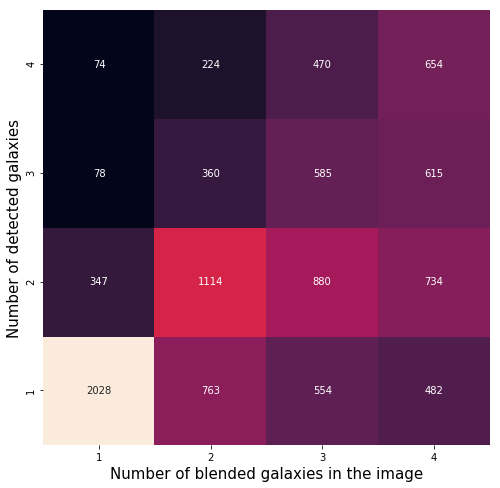

In [348]:
fig = plt.figure(figsize=(8,8))

sns.heatmap(heatmap_arr, annot=True, fmt=".0f", cbar = False)
plt.gca().invert_yaxis()
plt.xlabel('Number of blended galaxies in the image', fontsize = 15)
plt.ylabel('Number of detected galaxies', fontsize = 15)

locs_x, labels_x = plt.xticks()
locs_y, labels_y = plt.yticks()
plt.xticks(locs_x,labels = ('1','2','3','4'))
plt.yticks(locs_y,labels = ('1','2','3','4'))